# Dementia Modeling

## Data Set Loading / Exploratory Data Analysis

In [1]:
# Import dependencies
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.decomposition import PCA
import xgboost as xgb
from datetime import datetime
# import tensorflow as tf
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read in and display csv to dataframe
df = pd.read_csv('Resources/dementia_patients_health_data.csv')

df.head()

,Diabetic,AlcoholLevel,HeartRate,BloodOxygenLevel,BodyTemperature,Weight,MRI_Delay,Prescription,Dosage in mg,Age,...,Smoking_Status,APOE_ε4,Physical_Activity,Depression_Status,Cognitive_Test_Scores,Medication_History,Nutrition_Diet,Sleep_Quality,Chronic_Health_Conditions,Dementia
0,1,0.084974,98,96.230743,36.224852,57.563978,36.421028,NaN,NaN,60,...,Current Smoker,Negative,Sedentary,No,10,No,Low-Carb Diet,Poor,Diabetes,0
1,0,0.016973,78,93.032122,36.183874,56.832335,31.157633,Galantamine,12.0,61,...,Former Smoker,Positive,Moderate Activity,No,1,Yes,Low-Carb Diet,Poor,Heart Disease,1
2,0,0.009000,89,93.566504,37.326321,59.759066,37.640435,NaN,NaN,69,...,Former Smoker,Negative,Moderate Activity,No,8,No,Mediterranean Diet,Poor,Heart Disease,0
3,0,0.086437,60,93.906510,37.030620,58.266471,50.673992,Donepezil,23.0,78,...,Never Smoked,Negative,Mild Activity,Yes,5,Yes,Balanced Diet,Poor,Hypertension,1
4,1,0.150747,67,97.508994,36.062121,67.705027,27.810601,Memantine,20.0,77,...,Never Smoked,Positive,Mild Activity,No,0,Yes,Low-Carb Diet,Good,Diabetes,1


### Data Cleaning

In [3]:
# Check for missing values
df.isnull().sum()

Diabetic                       0
AlcoholLevel                   0
HeartRate                      0
BloodOxygenLevel               0
BodyTemperature                0
Weight                         0
MRI_Delay                      0
Prescription                 515
Dosage in mg                 515
Age                            0
Education_Level                0
Dominant_Hand                  0
Gender                         0
Family_History                 0
Smoking_Status                 0
APOE_ε4                        0
Physical_Activity              0
Depression_Status              0
Cognitive_Test_Scores          0
Medication_History             0
Nutrition_Diet                 0
Sleep_Quality                  0
Chronic_Health_Conditions    179
Dementia                       0
dtype: int64

In [4]:
# Replace missing dosage with 0
df['Dosage in mg'].fillna(0, inplace=True)

# Fill missing 'Prescription' values with None
df['Prescription'].fillna('None', inplace=True)

# Fill missing 'Prescription' values with None
df['Chronic_Health_Conditions'].fillna('None', inplace=True)

# Confirm changes
df.isnull().sum()

Diabetic                     0
AlcoholLevel                 0
HeartRate                    0
BloodOxygenLevel             0
BodyTemperature              0
Weight                       0
MRI_Delay                    0
Prescription                 0
Dosage in mg                 0
Age                          0
Education_Level              0
Dominant_Hand                0
Gender                       0
Family_History               0
Smoking_Status               0
APOE_ε4                      0
Physical_Activity            0
Depression_Status            0
Cognitive_Test_Scores        0
Medication_History           0
Nutrition_Diet               0
Sleep_Quality                0
Chronic_Health_Conditions    0
Dementia                     0
dtype: int64

In [5]:
# Determine the number of unique values in each column
df.nunique()

Diabetic                        2
AlcoholLevel                 1000
HeartRate                      41
BloodOxygenLevel             1000
BodyTemperature              1000
Weight                       1000
MRI_Delay                    1000
Prescription                    5
Dosage in mg                   11
Age                            31
Education_Level                 4
Dominant_Hand                   2
Gender                          2
Family_History                  2
Smoking_Status                  3
APOE_ε4                         2
Physical_Activity               3
Depression_Status               2
Cognitive_Test_Scores          11
Medication_History              2
Nutrition_Diet                  3
Sleep_Quality                   2
Chronic_Health_Conditions       4
Dementia                        2
dtype: int64

In [6]:
# Display the dataframe shape
print("Dataframe shape:", df.shape)

# Dataframe dtypes
df.info()

# Display basic statistical details
df.describe()

Dataframe shape: (1000, 24)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Diabetic                   1000 non-null   int64  
 1   AlcoholLevel               1000 non-null   float64
 2   HeartRate                  1000 non-null   int64  
 3   BloodOxygenLevel           1000 non-null   float64
 4   BodyTemperature            1000 non-null   float64
 5   Weight                     1000 non-null   float64
 6   MRI_Delay                  1000 non-null   float64
 7   Prescription               1000 non-null   object 
 8   Dosage in mg               1000 non-null   float64
 9   Age                        1000 non-null   int64  
 10  Education_Level            1000 non-null   object 
 11  Dominant_Hand              1000 non-null   object 
 12  Gender                     1000 non-null   object 
 13  Family_History       

,Diabetic,AlcoholLevel,HeartRate,BloodOxygenLevel,BodyTemperature,Weight,MRI_Delay,Dosage in mg,Age,Cognitive_Test_Scores,Dementia
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.513000,0.098429,79.383000,95.226051,36.761513,74.321326,30.103568,4.468500,74.908000,6.383000,0.485000
std,0.500081,0.058715,12.107556,2.929262,0.431701,14.463765,16.862170,6.453713,9.095068,3.180633,0.500025
min,0.000000,0.000414,60.000000,90.010677,36.002108,50.069731,0.094684,0.000000,60.000000,0.000000,0.000000
25%,0.000000,0.045505,68.000000,92.875017,36.395363,61.387339,16.237371,0.000000,67.000000,4.000000,0.000000
50%,1.000000,0.098235,79.000000,95.390420,36.784319,74.149204,29.577194,0.000000,75.000000,8.000000,0.000000
75%,1.000000,0.151840,90.000000,97.785111,37.126655,87.024034,44.176723,8.000000,83.000000,9.000000,1.000000
max,1.000000,0.199866,100.000000,99.999230,37.496809,99.982722,59.957599,23.000000,90.000000,10.000000,1.000000


### Outlier Cleanup

In [7]:
# Calculate Z-scores for numerical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns
df_z_scores = df[numerical_cols].apply(stats.zscore)

# Identify outliers with 3 standard deviations
outliers = np.abs(df_z_scores) > 3

# List of total outliers present in numerical data
outlier_counts = outliers.sum()
outlier_counts

Diabetic                 0
AlcoholLevel             0
HeartRate                0
BloodOxygenLevel         0
BodyTemperature          0
Weight                   0
MRI_Delay                0
Dosage in mg             0
Age                      0
Cognitive_Test_Scores    0
Dementia                 0
dtype: int64

### Categorical Distributions

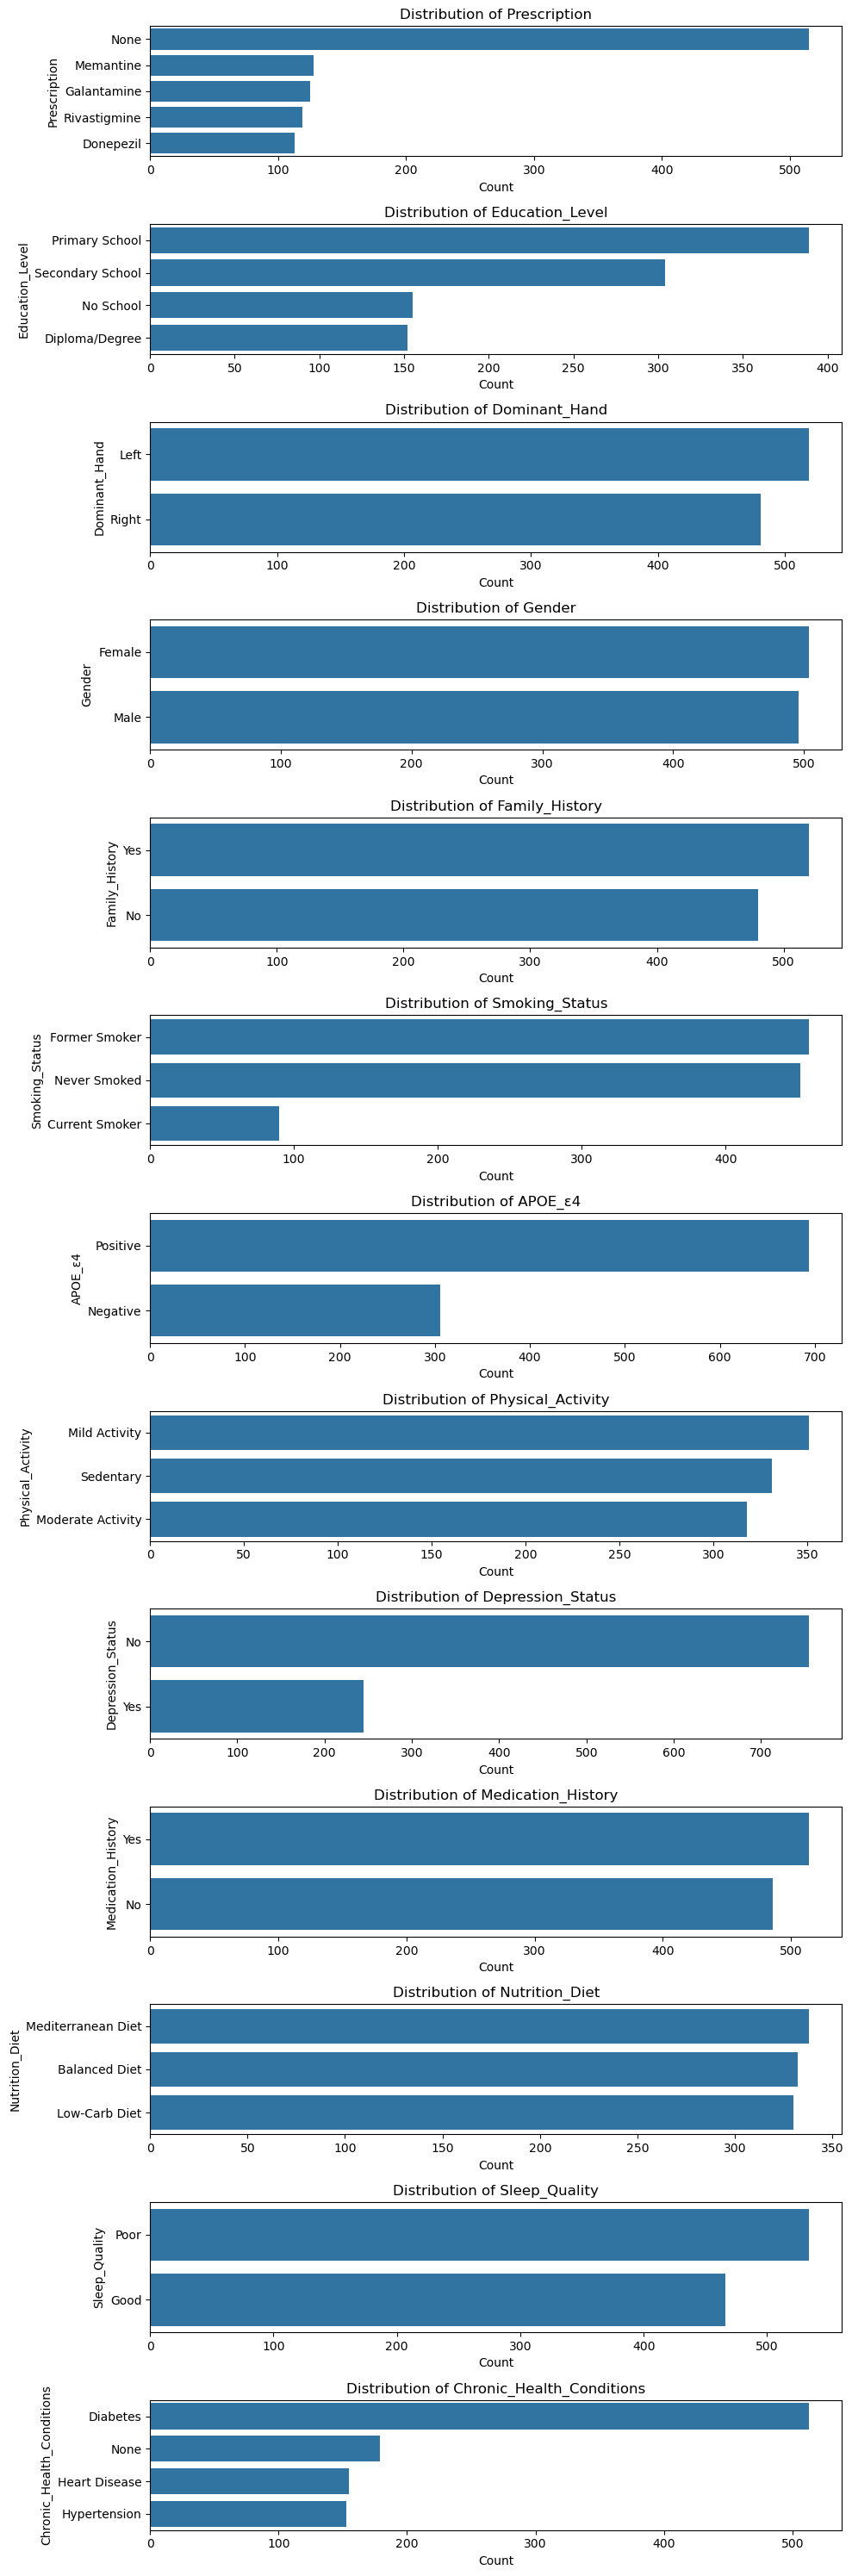

{'Prescription': Prescription
 None            515
 Memantine       128
 Galantamine     125
 Rivastigmine    119
 Donepezil       113
 Name: count, dtype: int64,
 'Education_Level': Education_Level
 Primary School      389
 Secondary School    304
 No School           155
 Diploma/Degree      152
 Name: count, dtype: int64,
 'Dominant_Hand': Dominant_Hand
 Left     519
 Right    481
 Name: count, dtype: int64,
 'Gender': Gender
 Female    504
 Male      496
 Name: count, dtype: int64,
 'Family_History': Family_History
 Yes    520
 No     480
 Name: count, dtype: int64,
 'Smoking_Status': Smoking_Status
 Former Smoker     458
 Never Smoked      452
 Current Smoker     90
 Name: count, dtype: int64,
 'APOE_ε4': APOE_ε4
 Positive    694
 Negative    306
 Name: count, dtype: int64,
 'Physical_Activity': Physical_Activity
 Mild Activity        351
 Sedentary            331
 Moderate Activity    318
 Name: count, dtype: int64,
 'Depression_Status': Depression_Status
 No     755
 Yes    245


In [8]:
# Set variable for all categorical variables
all_categorical_vars = df.select_dtypes(include=['object']).columns

# Set variable for the distribution of all categorical variables
all_categorical_summaries = {var: df[var].value_counts() for var in all_categorical_vars}

# Visualizing the distribution
fig, axs = plt.subplots(len(all_categorical_vars), 1, figsize=(10, 30))

# Loop through the categories
for i, var in enumerate(all_categorical_vars):
    sns.countplot(y=var, data=df, ax=axs[i], order = df[var].value_counts().index)
    axs[i].set_title(f'Distribution of {var}')
    axs[i].set_xlabel('Count')
    axs[i].set_ylabel(var)

plt.tight_layout()
plt.show()

all_categorical_summaries

### Numerical Distributions

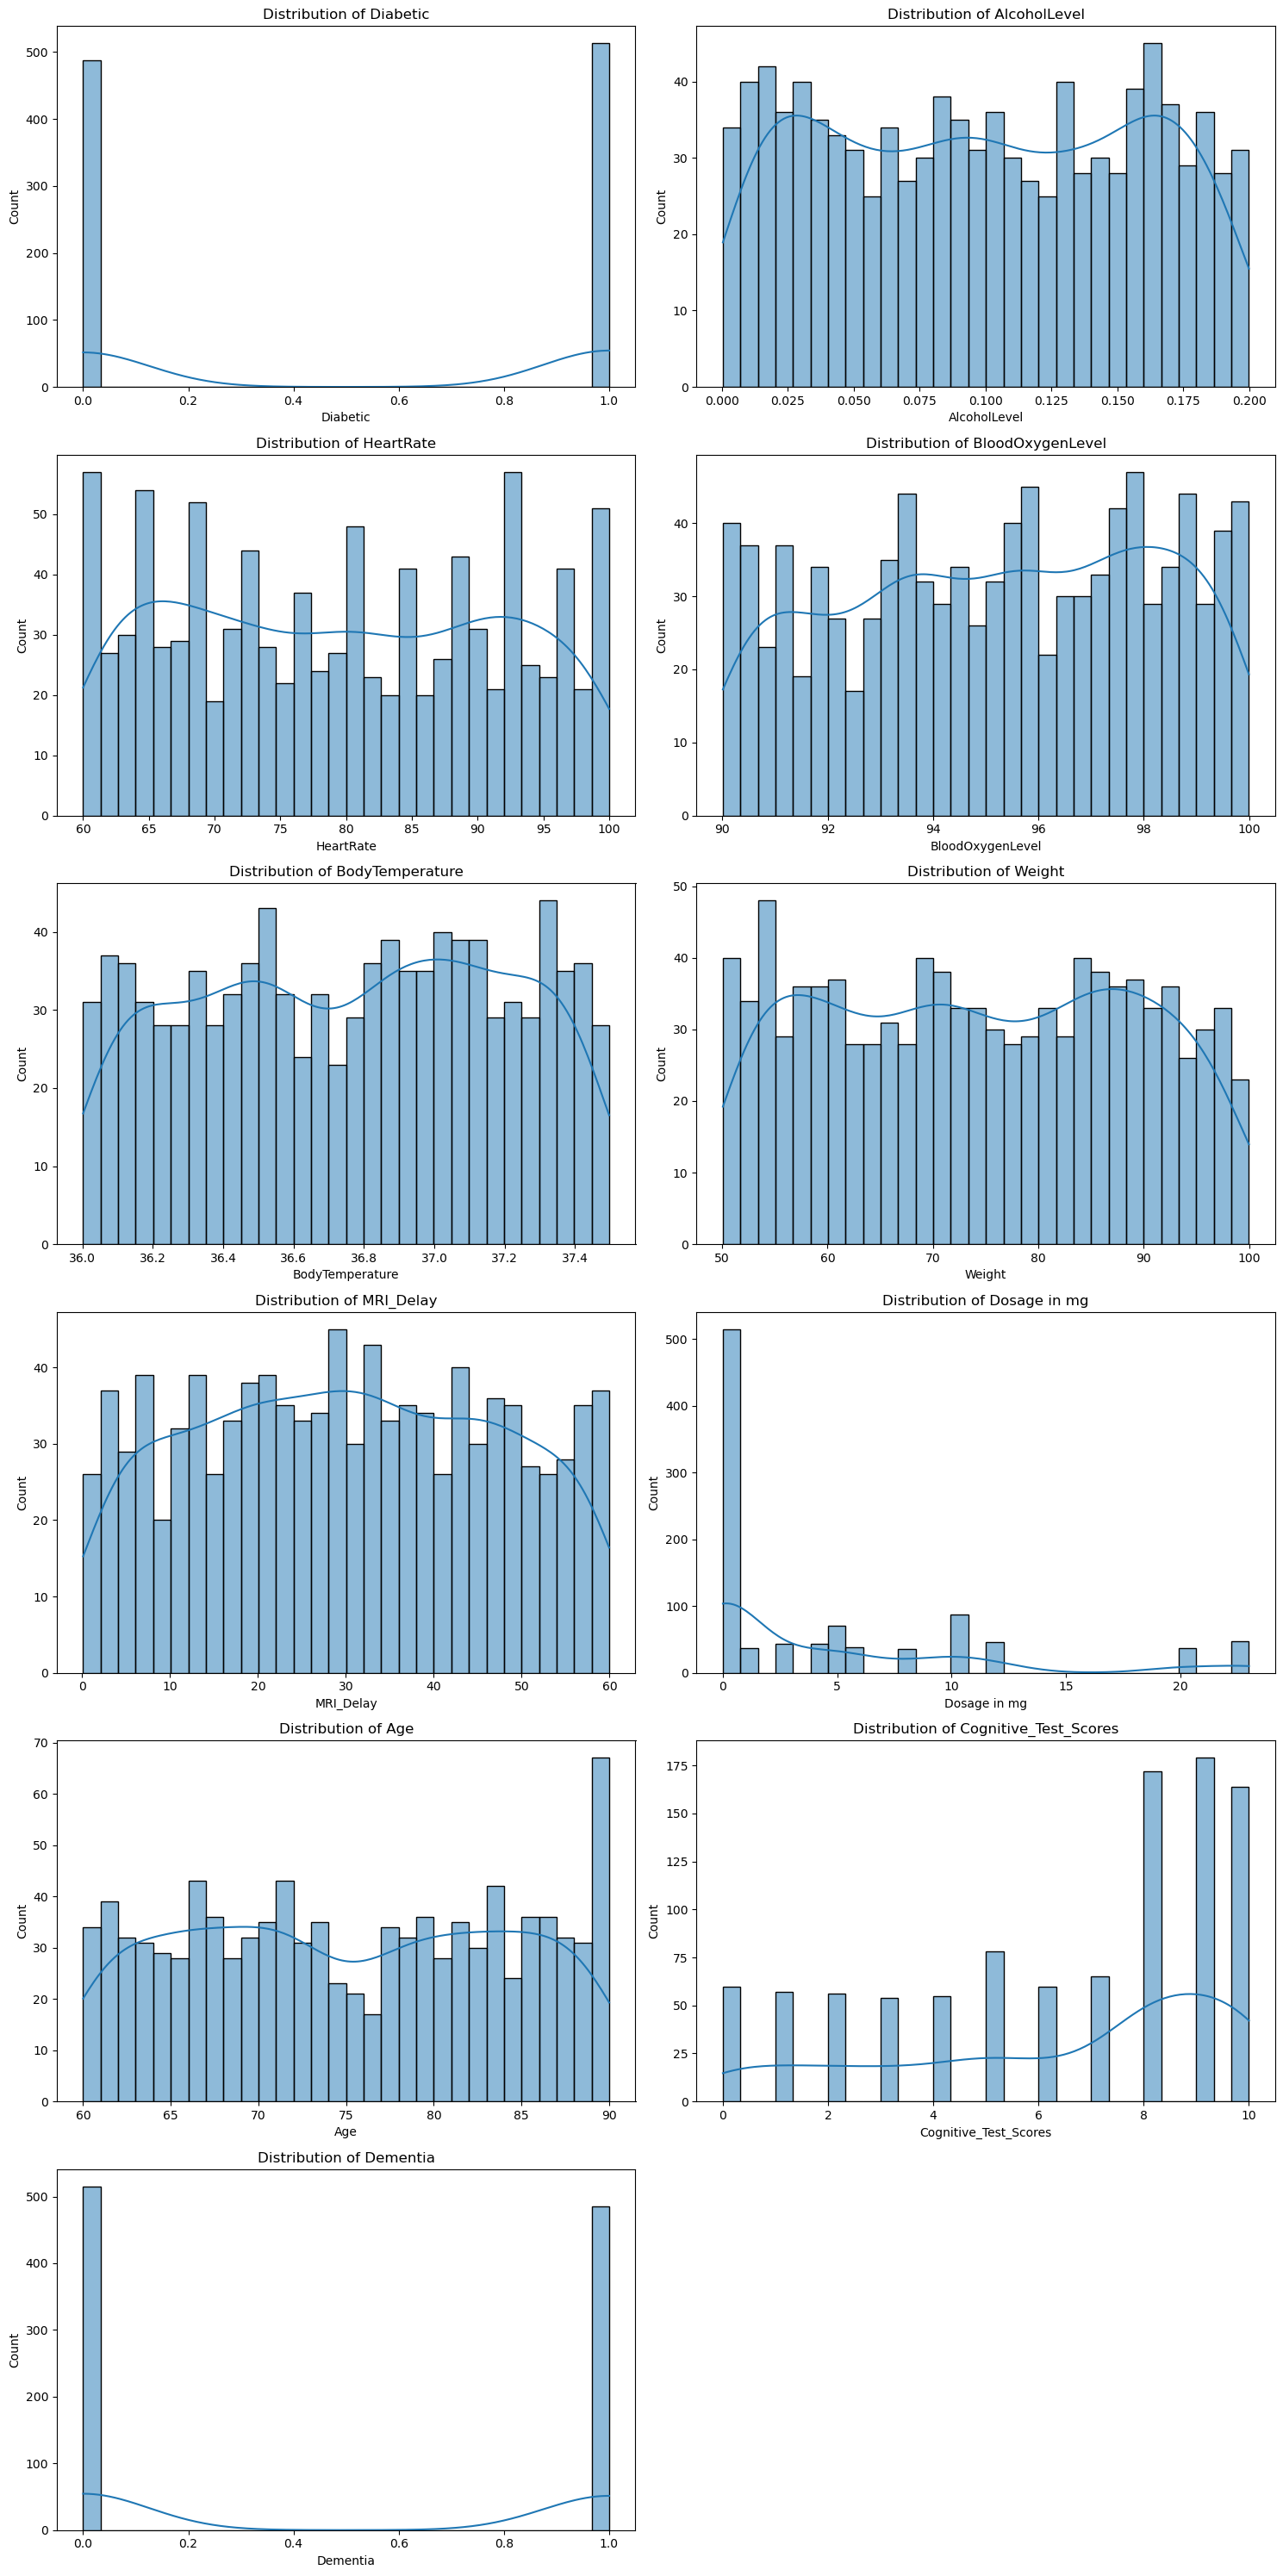

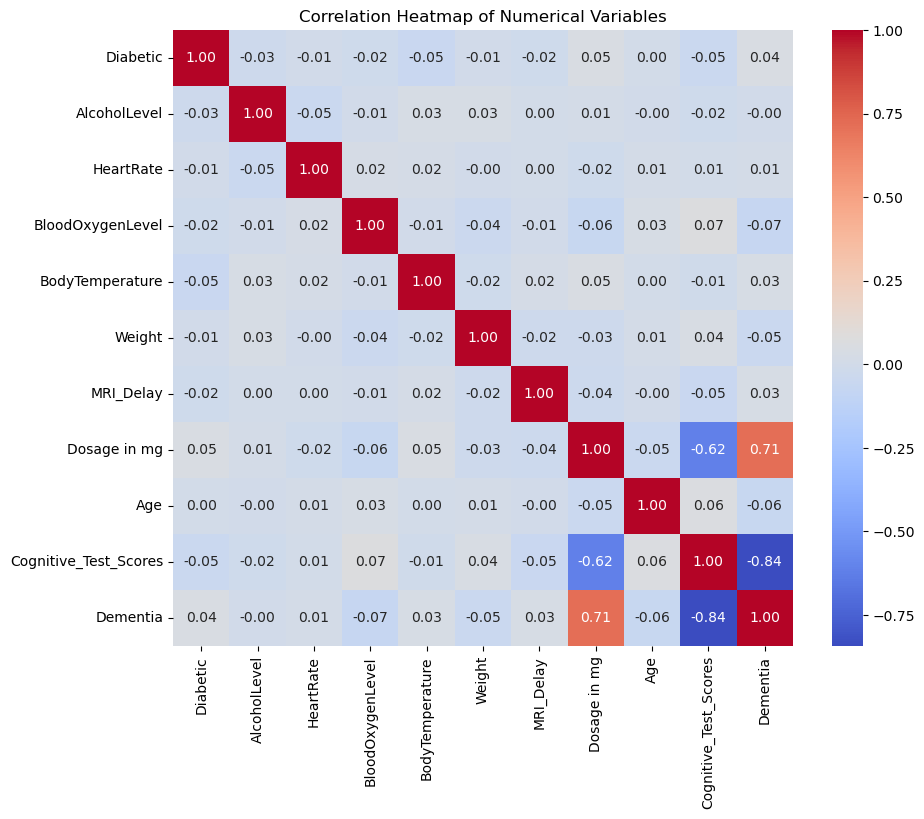

In [9]:
# Calculate the required number of rows to fit all numerical columns
num_plots = len(numerical_cols)
num_rows = (num_plots // 2) + (num_plots % 2)

# Plotting histograms for selected numerical variables
fig, axs = plt.subplots(num_rows, 2, figsize=(15, num_rows * 5))

for i, col in enumerate(numerical_cols):
    sns.histplot(df[col], ax=axs[i//2, i%2], kde=True, bins=30)
    axs[i//2, i%2].set_title(f'Distribution of {col}')

# If the number of plots is odd, hide the last subplot if unused
if num_plots % 2 != 0:
    axs[-1, -1].axis('off')

plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Variables')
plt.show()

### Target Counts by Feature Values

In [10]:
# Looping through each feature to output target counts
for column in df.drop('Dementia', axis=1).columns:
    # Perform the groupby operation and count target status per value within features
    counts = df.groupby([column, 'Dementia']).size().unstack(fill_value=0)
    print(f"Feature: {column}")
    print(counts)
    print("\n-----\n")

Feature: Diabetic
Dementia    0    1
Diabetic          
0         262  225
1         253  260

-----

Feature: AlcoholLevel
Dementia      0  1
AlcoholLevel      
0.000414      0  1
0.000751      1  0
0.000949      0  1
0.001226      0  1
0.001327      1  0
...          .. ..
0.198686      1  0
0.198797      0  1
0.198963      1  0
0.198989      1  0
0.199866      1  0

[1000 rows x 2 columns]

-----

Feature: HeartRate
Dementia    0   1
HeartRate        
60         16  16
61         18   7
62         10  17
63         10  20
64         17   9
65         13  15
66         15  13
67         15  14
68         19   9
69         15   9
70          7  12
71         13  18
72         14  10
73         11   9
74         15  13
75         12  10
76          9   9
77          8  11
78         17   7
79         15  12
80         11   9
81         12  16
82         12  11
83         12   8
84         11  14
85         10   6
86          9  11
87         12  14
88          7  12
89         14  10
9

### Final Cleaning Based on EDA

In [11]:
# Remove Prescription and Dosage in mg from data set, the only values to require a dementia diagnosis
df = df.drop(['Prescription', 'Dosage in mg'], axis=1)

## Separating Features from Target

In [12]:
# Separate features from target and convert categorical data
X = df.drop('Dementia', axis=1)
X = pd.get_dummies(X)
y = df['Dementia']

# # Split the dataset into training (80%) and test (20%) sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [13]:
# Review features
X.head()

,Diabetic,AlcoholLevel,HeartRate,BloodOxygenLevel,BodyTemperature,Weight,MRI_Delay,Age,Cognitive_Test_Scores,Education_Level_Diploma/Degree,...,Medication_History_Yes,Nutrition_Diet_Balanced Diet,Nutrition_Diet_Low-Carb Diet,Nutrition_Diet_Mediterranean Diet,Sleep_Quality_Good,Sleep_Quality_Poor,Chronic_Health_Conditions_Diabetes,Chronic_Health_Conditions_Heart Disease,Chronic_Health_Conditions_Hypertension,Chronic_Health_Conditions_None
0,1,0.084974,98,96.230743,36.224852,57.563978,36.421028,60,10,False,...,False,False,True,False,False,True,True,False,False,False
1,0,0.016973,78,93.032122,36.183874,56.832335,31.157633,61,1,False,...,True,False,True,False,False,True,False,True,False,False
2,0,0.009000,89,93.566504,37.326321,59.759066,37.640435,69,8,False,...,False,False,False,True,False,True,False,True,False,False
3,0,0.086437,60,93.906510,37.030620,58.266471,50.673992,78,5,False,...,True,True,False,False,False,True,False,False,True,False
4,1,0.150747,67,97.508994,36.062121,67.705027,27.810601,77,0,False,...,True,False,True,False,True,False,True,False,False,False


### StandardScaler Instance

In [14]:
# # Instantiate a StandardScaler instance
# scaler = StandardScaler()

# # Fit the Standard Scaler with the training data
# X_scaler = scaler.fit(X_train)

# # Scale the training data
# X_train_scaled = X_scaler.transform(X_train)
# X_test_scaled = X_scaler.transform(X_test)

## XGBoost Model

### PCA Scaling with pd.get_dummies()

In [15]:
# Reset X and y
X = df.drop('Dementia', axis=1)
y = df['Dementia']

# Selecting numerical features for PCA
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
X_numerical = X[numerical_features]

# If you have categorical features you want to keep outside of PCA, select them here
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
X_categorical = pd.get_dummies(X[categorical_features])


In [16]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numerical)

pca = PCA(n_components=9)
X_pca = pca.fit_transform(X_scaled)

# If you have categorical features
X_final = np.concatenate((X_pca, X_categorical.values), axis=1)

In [17]:
pca.explained_variance_ratio_

array([0.12658515, 0.12041524, 0.11894615, 0.11220669, 0.10993159,
       0.10770265, 0.1059924 , 0.10110172, 0.0971184 ])

### Initial Modeling

In [18]:
# Confirm percentage that have dementia in data set
sum(y)/len(y)

0.485

In [19]:
# Stratify to normalize the test and train ratios
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=1, stratify=y)

In [20]:
# Confirm training data properly stratefied
sum(y_train)/len(y_train)

0.485

In [21]:
# Confirm test data properly stratefied
sum(y_test)/len(y_test)

0.485

In [22]:
# Instantiate first model
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', seed=1)
first_model = xgb_clf.fit(X_train, y_train, verbose=True, early_stopping_rounds=10, eval_metric='aucpr', eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.96928
[1]	validation_0-aucpr:0.97548
[2]	validation_0-aucpr:0.97610
[3]	validation_0-aucpr:0.97556
[4]	validation_0-aucpr:0.97918
[5]	validation_0-aucpr:0.98071
[6]	validation_0-aucpr:0.98002
[7]	validation_0-aucpr:0.98273
[8]	validation_0-aucpr:0.98312
[9]	validation_0-aucpr:0.98575
[10]	validation_0-aucpr:0.98521
[11]	validation_0-aucpr:0.98665
[12]	validation_0-aucpr:0.98786
[13]	validation_0-aucpr:0.98790
[14]	validation_0-aucpr:0.98810
[15]	validation_0-aucpr:0.98866
[16]	validation_0-aucpr:0.98965
[17]	validation_0-aucpr:0.99065
[18]	validation_0-aucpr:0.99087
[19]	validation_0-aucpr:0.99044
[20]	validation_0-aucpr:0.99147
[21]	validation_0-aucpr:0.99184
[22]	validation_0-aucpr:0.99172
[23]	validation_0-aucpr:0.99146
[24]	validation_0-aucpr:0.99168
[25]	validation_0-aucpr:0.99226
[26]	validation_0-aucpr:0.99242
[27]	validation_0-aucpr:0.99246
[28]	validation_0-aucpr:0.99225
[29]	validation_0-aucpr:0.99257
[30]	validation_0-aucpr:0.99225
[31]	validation_0-

c:\Users\dcase\anaconda3\envs\dev\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\dcase\anaconda3\envs\dev\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


In [23]:
# Evaluate the model
y_pred = first_model.predict(X_test)
y_pred_proba = first_model.predict_proba(X_test)[:, 1]

# Accuracy and ROC AUC Scores
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC: {roc_auc}")

Accuracy: 0.95
ROC AUC: 0.9952957661895706


In [24]:
# Iterate through all pca components and combine them with the categorical features
pca_feature_names = [f'PCA_Component_{i}' for i in range(1, pca.n_components_ + 1)]
categorical_feature_names = X_categorical.columns.tolist()
all_feature_names = pca_feature_names + categorical_feature_names

# Pull the feature importance metrics from the model
importance = first_model.feature_importances_

# Output to dataframe
features_first_model = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

features_first_model.head(40)

,Feature,Importance
27,Depression_Status_No,0.682451
0,PCA_Component_1,0.073519
8,PCA_Component_9,0.058706
22,APOE_ε4_Negative,0.043219
36,Chronic_Health_Conditions_Diabetes,0.029950
10,Education_Level_No School,0.016510
2,PCA_Component_3,0.011269
7,PCA_Component_8,0.011238
5,PCA_Component_6,0.010903
24,Physical_Activity_Mild Activity,0.010787


### Random CV Modeling

In [25]:
# Set hyperparameters for RandomizedSearch
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [26]:
# Instantiate model for RandomizedSearch
xgb_clf = xgb.XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)

In [27]:
# Set variables for SKFolds and RandomizedSearch parameters
folds = 5
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb_clf, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X,y), verbose=3, random_state=1001 )
random_search.fit(X_final, y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


c:\Users\dcase\anaconda3\envs\dev\lib\site-packages\xgboost\core.py:160: UserWarning: [20:35:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x000001DDB55977D0>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=600, n_jobs=None,
                                           nthread=1, num_parallel_tree=None, ...),
                   n_iter=5, n_jobs=4,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0.5, 1, 1.5, 2, 5],
                                        'max_depth': [3, 4, 5],
                                        'min_child_weight': [1, 5, 10],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=1001, scoring='roc_auc', verbose=3)

In [28]:
# Print results to pull optimal hyperparameter results
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)



 All results:
{'mean_fit_time': array([0.08233333, 0.12923474, 0.11294999, 0.06911001, 0.13633275]), 'std_fit_time': array([0.00706346, 0.00498132, 0.00100456, 0.00165148, 0.0027557 ]), 'mean_score_time': array([0.00219245, 0.00280647, 0.00259447, 0.0017283 , 0.002353  ]), 'std_score_time': array([0.00039878, 0.00028999, 0.00080085, 0.00073965, 0.00067218]), 'param_subsample': masked_array(data=[1.0, 0.6, 0.8, 1.0, 0.8],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_min_child_weight': masked_array(data=[5, 1, 5, 5, 1],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[3, 5, 5, 5, 4],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_gamma': masked_array(data=[5, 1.5, 1, 5, 1],
             mask=[False, False, False, False, False],
       fill_value='?',
            dt

In [29]:
# Apply results to new variable for modeling
best_params = {
    'subsample': 0.6,
    'min_child_weight': 1,
    'max_depth': 5,
    'gamma': 1.5,
    'colsample_bytree': 0.8,
    'learning_rate': 0.02,
    'n_estimators': 600,
    'objective': 'binary:logistic',
    'silent': True,
    'nthread': 1,
    'seed': 1
}

# Instantiate the classifier with the best parameters
optimized_xgb_clf = xgb.XGBClassifier(**best_params)

# Fit the classifier to the training data
random_xgb_clf = optimized_xgb_clf.fit(X_train, y_train, verbose=True, early_stopping_rounds=10, eval_metric='aucpr', eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.96725


c:\Users\dcase\anaconda3\envs\dev\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\dcase\anaconda3\envs\dev\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-aucpr:0.96969
[2]	validation_0-aucpr:0.98067
[3]	validation_0-aucpr:0.98026
[4]	validation_0-aucpr:0.97932
[5]	validation_0-aucpr:0.97948
[6]	validation_0-aucpr:0.98501
[7]	validation_0-aucpr:0.98714
[8]	validation_0-aucpr:0.98785
[9]	validation_0-aucpr:0.99014
[10]	validation_0-aucpr:0.99042
[11]	validation_0-aucpr:0.99206
[12]	validation_0-aucpr:0.99117
[13]	validation_0-aucpr:0.99079
[14]	validation_0-aucpr:0.99032
[15]	validation_0-aucpr:0.98956
[16]	validation_0-aucpr:0.98879
[17]	validation_0-aucpr:0.98877
[18]	validation_0-aucpr:0.98916
[19]	validation_0-aucpr:0.98790
[20]	validation_0-aucpr:0.98770


In [30]:
# Evaluate the model
y_pred = random_xgb_clf.predict(X_test)
y_pred_proba = random_xgb_clf.predict_proba(X_test)[:, 1]

# Accuracy and ROC AUC Scores
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC: {roc_auc}")

Accuracy: 0.935
ROC AUC: 0.9918426583925534


In [31]:
# Iterate through all pca components and combine them with the categorical features
pca_feature_names = [f'PCA_Component_{i}' for i in range(1, pca.n_components_ + 1)]
categorical_feature_names = X_categorical.columns.tolist()
all_feature_names = pca_feature_names + categorical_feature_names

# Pull the feature importance metrics from the model
importance = random_xgb_clf.feature_importances_

# Output to dataframe
features_random_model = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

features_random_model.head(40)

,Feature,Importance
27,Depression_Status_No,0.287552
28,Depression_Status_Yes,0.257859
0,PCA_Component_1,0.121893
8,PCA_Component_9,0.073824
19,Smoking_Status_Current Smoker,0.033766
22,APOE_ε4_Negative,0.031174
20,Smoking_Status_Former Smoker,0.021145
5,PCA_Component_6,0.020236
6,PCA_Component_7,0.016008
21,Smoking_Status_Never Smoked,0.015922


### Grid Search CV Modeling

In [32]:
# Instantiate the model for GridSearch
xgb_clf = xgb.XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic', silent=True, nthread=1)

# Set hyperparameters to variable
params = {
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5]
}

In [33]:
# Set variables for SKFolds and GridSearch parameters
folds = 5
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)

grid_search = GridSearchCV(xgb_clf, param_grid=params, scoring='roc_auc', n_jobs=-1, cv=skf, verbose=3)

In [34]:
# Fit the GridSearch to the data
grid_search.fit(X_final, y)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


c:\Users\dcase\anaconda3\envs\dev\lib\site-packages\xgboost\core.py:160: UserWarning: [20:35:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_typ...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=600,
                                     n_jobs=None, nthread=1,
                                     num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0.5, 1, 1.5, 2], 'max_depth': [3, 4, 5],
                         'min_child_weight': [1, 5, 10],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='roc_auc', verbose=3)

In [35]:
# Print the results of the optimal hyperparameters
print("Best parameters found: ", grid_search.best_params_)
print("Best AUC score found: ", grid_search.best_score_)

Best parameters found:  {'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.6}
Best AUC score found:  0.9975978380542487


In [36]:
# Assign variable to the best model
best_model = grid_search.best_estimator_

In [37]:
# Evaluate the model
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC: {roc_auc}")

Accuracy: 1.0
ROC AUC: 1.0


In [38]:
# Iterate through all pca components and combine them with the categorical features
pca_feature_names = [f'PCA_Component_{i}' for i in range(1, pca.n_components_ + 1)]
categorical_feature_names = X_categorical.columns.tolist()
all_feature_names = pca_feature_names + categorical_feature_names

# Pull the feature importance metrics from the model
importance = best_model.feature_importances_

# Output to dataframe
features_best_model = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

features_best_model.head(40)

,Feature,Importance
27,Depression_Status_No,0.199962
28,Depression_Status_Yes,0.182444
0,PCA_Component_1,0.067798
19,Smoking_Status_Current Smoker,0.060160
8,PCA_Component_9,0.055966
23,APOE_ε4_Positive,0.043251
22,APOE_ε4_Negative,0.042060
9,Education_Level_Diploma/Degree,0.017688
5,PCA_Component_6,0.016612
7,PCA_Component_8,0.016529


In [39]:
print(confusion_matrix(y_test, y_pred))

[[103   0]
 [  0  97]]


In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       103
           1       1.00      1.00      1.00        97

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



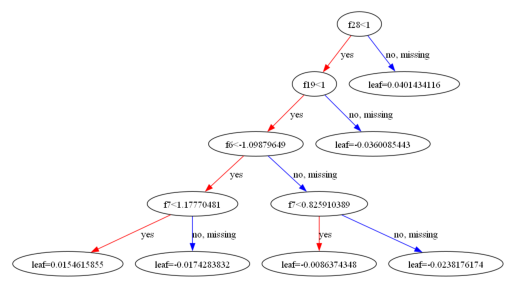

In [41]:
xgb.plot_tree(best_model, num_trees=0)
plt.show()

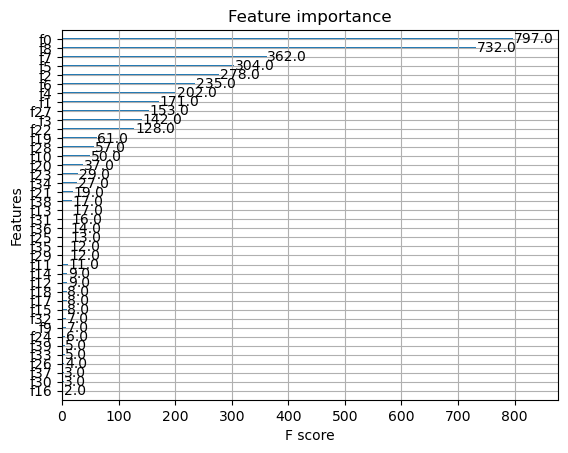

In [48]:
xgb.plot_importance(best_model)
plt.show()

<Figure size 1200x800 with 0 Axes>

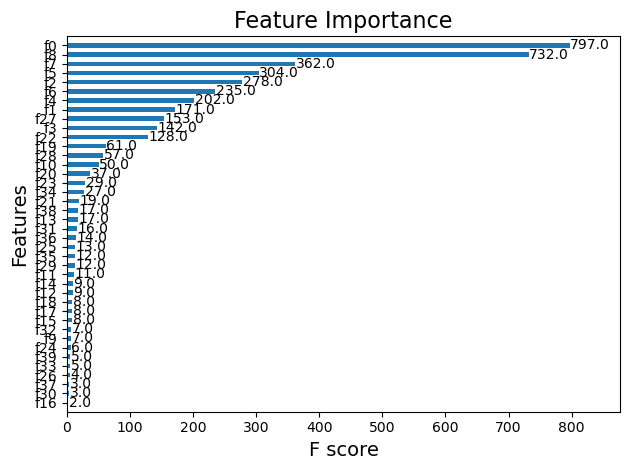

In [63]:
plt.figure(figsize=(12, 8))  # Set a larger figure size to accommodate all features
xgb.plot_importance(best_model, height=0.5, grid=False, show_values=True)  # Removed max_num_features to show all
plt.title('Feature Importance', fontsize=16)  # Add a title
plt.xlabel('F score', fontsize=14)  # Set x-axis label
plt.ylabel('Features', fontsize=14)  # Set y-axis label
plt.yticks(fontsize=10)  # Set the font size of y-axis ticks
plt.xticks(fontsize=10)  # Set the font size of x-axis ticks
plt.tight_layout()  # Adjust the layout
plt.show()